<a href="https://colab.research.google.com/github/p2x0i/Liqudity-Trading-/blob/main/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I set out to develop a sentiment analysis model for stock market news articles. The goal was to classify news articles as either positive or negative based on their content. Initially, I implemented the model using PyTorch, using the powerful XLM-RoBERTa transformer model from Hugging Face. LAter, I rewrote the model using JAX and Flax to learn the differences between these frameworks.


In [15]:
!pip install transformers datasets sentencepiece chardet scikit-learn torch torchvision torchaudio --quiet


In [23]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import chardet
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import re

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import os

data_path = '/content/drive/MyDrive/Colab Notebooks/sorted_news'



neg_path = os.path.join(data_path, 'neg')
pos_path = os.path.join(data_path, 'pos')


I will load the stock market news dataset and preprocess it by removing unnecessary characters, lowercasing, and removing URLs and emails.


In [17]:
texts = []
labels = []
import chardet

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
    result = chardet.detect(raw_data)
    return result['encoding']


# read negative reviews
neg_files = os.listdir(neg_path)
for i in neg_files:
    file_path = os.path.join(neg_path, i)
    encoding = detect_encoding(file_path)
    with open(file_path, 'r', encoding=encoding) as f:
        texts.append(f.read())
        labels.append(0)  #'0' for negative sentiment

# read positive reviews
pos_files = os.listdir(pos_path)
for i in pos_files:
    file_path = os.path.join(pos_path, i)
    encoding = detect_encoding(file_path)
    with open(file_path, 'r', encoding=encoding) as f:
        texts.append(f.read())
        labels.append(1)  #'1' for positive sentiment

print(f"Total samples: {len(texts)}")


Total samples: 1706


In [24]:
def preprocess_text(text):
    # remove whitespaces
    text = text.strip()

    # remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # remove emails
    text = re.sub(r'\S+@\S+', '', text)


    # lowercase
    text = text.lower()

    return text

# Apply to all texts
texts = [preprocess_text(text) for text in texts]

I will split the data into training, validation, and test sets using stratified sampling to maintain the class distribution.


In [25]:
# Split into training and temporary set
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2,  stratify=labels
)

# Split temporary set into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")


Training samples: 1364
Validation samples: 171
Test samples: 171


I will use the tokenizer from the pre-trained xlm-roberta-base model hugging face version
 to tokenize the text data.



XLM-RoBERTa
*   Multilingual pre-training and strong contextualization
*   Generally outperforms other traditional LSTMs
*   Self-attention mechanism
*   Compared to BERT stronger in other languages-not english-


    



I tokenized the text data to prepare it for the model.

In [26]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding.get('token_type_ids', torch.tensor([0]*self.max_len)).squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [28]:
MAX_LEN = 64
BATCH_SIZE = 8

In [29]:
# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [30]:
# Load pre-trained model with a classification head
config = AutoConfig.from_pretrained(model_name, num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 defined training and evaluation loops using standard PyTorch practices:

Optimizer: Used AdamW optimizer with a learning rate of 2e-5.

Learning Rate Scheduler: Implemented a linear scheduler with warmup.

Loss Function: Utilized CrossEntropyLoss



In [31]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [32]:
def train_epoch(
    model, data_loader, loss_fn, optimizer, device, scheduler, n_examples
):
    model.train()

    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [33]:
def eval_model(
    model, data_loader, loss_fn, device, n_examples
):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
# Training loop
history = defaultdict(list)
best_accuracy = 0

for i in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 20)

    train_acc, train_loss = train_epoch(
        model, train_loader, loss_fn, optimizer, device, scheduler, len(train_dataset)
    )

    print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model, val_loader, loss_fn, device, len(val_dataset)
    )

    print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')
    print()

    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)

    # Save best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/3
--------------------


Training: 100%|██████████| 171/171 [31:31<00:00, 11.06s/it]


Train loss: 0.6799, accuracy: 0.5740


Evaluating: 100%|██████████| 22/22 [00:52<00:00,  2.36s/it]


Validation loss: 0.6420, accuracy: 0.6550

Epoch 2/3
--------------------


Training: 100%|██████████| 171/171 [30:06<00:00, 10.56s/it]


Train loss: 0.5921, accuracy: 0.6928


Evaluating: 100%|██████████| 22/22 [00:42<00:00,  1.92s/it]


Validation loss: 0.5636, accuracy: 0.6959

Epoch 3/3
--------------------


Training: 100%|██████████| 171/171 [29:20<00:00, 10.29s/it]


Train loss: 0.4693, accuracy: 0.7881


Evaluating: 100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


Validation loss: 0.5224, accuracy: 0.7485



In [34]:
# Load the best model
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)


<ipython-input-34-5607eb650b48>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))


In [35]:
def get_predictions(model, data_loader):
    model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predicting'):
            texts.extend(batch['text'])
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            prediction_probs.extend(torch.nn.functional.softmax(logits, dim=1).cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    real_values = np.array(real_values)
    return texts, predictions, prediction_probs, real_values

texts, y_pred, y_pred_probs, y_test = get_predictions(
    model, test_loader
)


Predicting: 100%|██████████| 22/22 [01:23<00:00,  3.77s/it]


In [36]:
# Classification - Provided precision, recall, F1-score, and support for each class.
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.92      0.79        77
    Positive       0.91      0.67      0.77        94

    accuracy                           0.78       171
   macro avg       0.80      0.80      0.78       171
weighted avg       0.82      0.78      0.78       171



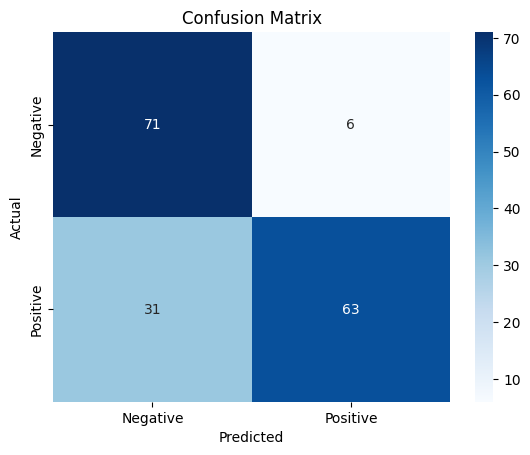

In [37]:
# Confusion Matrix-  Visualized the model's performance in distinguishing between positive and negative sentiments
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [38]:
# Accuracy Score
acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {acc:.4f}')


Test Accuracy: 0.7836


In [34]:
# JAX and Flax
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html --quiet
!pip install flax --quiet

!pip install transformers datasets --quiet


In [35]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
from transformers import FlaxAutoModelForSequenceClassification
import optax
from transformers import AutoTokenizer, FlaxAutoModelForSequenceClassification

I will use the FlaxAutoModelForSequenceClassification from Hugging Face Transformers to load the pre-trained model in JAX/Flax.


I used the same tokenizer as before but ensured that the data was formatted correctly for JAX.



In [36]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

#model in Flax
model = FlaxAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing FlaxXLMRobertaForSequenceClassification: {('lm_head', 'dense', 'bias'), ('lm_head', 'bias'), ('lm_head', 'dense', 'kernel'), ('lm_head', 'layer_norm', 'bias'), ('lm_head', 'layer_norm', 'scale')}
- This IS expected if you are initializing FlaxXLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxXLMRobertaForSeq

In [37]:
from datasets import Dataset

# Prepare datasets
train_data = {'text': train_texts, 'labels': train_labels}
val_data = {'text': val_texts, 'labels': val_labels}
test_data = {'text': test_texts, 'labels': test_labels}

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

I will use the tokenizer from the pre-trained xlm-roberta-base model to tokenize the text data.

Converted the datasets into Hugging Face Dataset objects and set the format to JAX tensors.



In [38]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
    )

# Prepare datasets
train_data = {'text': train_texts, 'labels': train_labels}
val_data = {'text': val_texts, 'labels': val_labels}
test_data = {'text': test_texts, 'labels': test_labels}

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to JAX tensors
columns = ['input_ids', 'attention_mask', 'labels']
train_dataset.set_format(type='jax', columns=columns)
val_dataset.set_format(type='jax', columns=columns)
test_dataset.set_format(type='jax', columns=columns)

Map:   0%|          | 0/1364 [00:00<?, ? examples/s]

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

I will define the optimizer, learning rate, and training state.



In [46]:
from flax.training import train_state
from typing import Any

class TrainState(train_state.TrainState):
    rng: Any  # Add PRNG key to the training state
 #One of the challenges was managing the PRNG keys required for stochastic operations like dropout.

In [49]:
# my params
learning_rate = 2e-5
num_epochs = 3
batch_size = 2

tx = optax.adamw(learning_rate)

#  parameters and PRNG key
rng = jax.random.PRNGKey(0)

# Create the training state using the custom TrainState class
state = TrainState.create(
    apply_fn=model.__call__,
    params=model.params,
    tx=tx,
    rng=rng  #  the rng
)

I will create data loaders to generate batches of data for training and evaluation.



In [42]:
def data_loader(dataset, batch_size):
    steps_per_epoch = len(dataset) // batch_size
    while True:
        # Shuffle dataset at each epoch
        perm = np.random.permutation(len(dataset))
        for i in range(steps_per_epoch):
            batch_indices = perm[i * batch_size : (i + 1) * batch_size]
            batch = dataset.select(batch_indices)
            yield {
                'input_ids': np.array(batch['input_ids']),
                'attention_mask': np.array(batch['attention_mask']),
                'labels': np.array(batch['labels'])
            }

# Create data loaders
train_data_loader = data_loader(train_dataset, BATCH_SIZE)
val_data_loader = data_loader(val_dataset, BATCH_SIZE)

I will define the loss function using cross-entropy loss and create a training step function with JIT compilation for efficiency.

In [43]:
def compute_loss(params, batch):
    logits = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        params=params,
        train=True
    ).logits
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits, batch['labels']
    ).mean()
    return loss

@jax.jit
def train_step(state, batch):
    # Split the rng for reproducibility
    rng, new_rng = jax.random.split(state.rng)

    def loss_fn(params):
        logits = state.apply_fn(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            params=params,
            dropout_rng=rng,  # Pass the rng to the model
            train=True
        ).logits
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits, batch['labels']
        ).mean()
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)

    # Update the state with new parameters and rng
    new_state = state.apply_gradients(grads=grads)
    new_state = new_state.replace(rng=new_rng)

    return new_state, loss



I will define an evaluation function to compute the accuracy on the validation set.



In [44]:
def compute_metrics(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy

@jax.jit
def eval_step(params, batch):
    logits = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        params=params,
        train=False
    ).logits
    return compute_metrics(logits, batch['labels'])


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    # Training
    batch_losses = []
    for batch in tqdm(train_data_loader, total=len(train_dataset)//batch_size):
        state, loss = train_step(state, batch)
        batch_losses.append(loss)
    train_loss = np.mean(batch_losses)
    print(f"Training loss: {train_loss:.4f}")

    # Evaluation
    val_accuracies = []
    for batch in tqdm(val_data_loader, total=len(val_dataset)//batch_size):
        accuracy = eval_step(state.params, batch)
        val_accuracies.append(accuracy)
    val_accuracy = np.mean(val_accuracies)
    print(f"Validation accuracy: {val_accuracy:.4f}")



In [ ]:
# Create test data loader which generates batches of data from the test dataset
def test_data_loader(dataset, batch_size):
    steps = len(dataset) // batch_size
    for i in range(steps):
        batch = dataset[i * batch_size: (i + 1) * batch_size]
        yield {
            'input_ids': np.array(batch['input_ids']),
            'attention_mask': np.array(batch['attention_mask']),
            'labels': np.array(batch['labels'])
        }

test_loader = test_data_loader(test_dataset, batch_size)

# eval on test set
test_accuracies = []
for batch in tqdm(test_loader, total=len(test_dataset)//batch_size):
    accuracy = eval_step(state.params, batch)
    test_accuracies.append(accuracy)
test_accuracy = np.mean(test_accuracies)
print(f"Test accuracy: {test_accuracy:.4f}")


In [ ]:
# predictions and true labels
test_loader = test_data_loader(test_dataset, batch_size)

# create lists to store the predictions and true labels
all_predictions = []
all_labels = []

# go over the test data loader
for batch in tqdm(test_loader, total=len(test_dataset)//batch_size):
    logits = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        params=state.params,
        train=False # make sure that the model is in eval mode
    ).logits

    # Convert logits to predictions by taking the argmax over the classes
    predictions = jnp.argmax(logits, axis=-1)
    all_predictions.extend(np.array(predictions))
    all_labels.extend(np.array(batch['labels']))

# Label Report
print('Label Report:')
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Positive']))

# Confusion Matrix gives a detailed breakdown of correct and incorrect classifications.

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


I observed  throughout this project the key differences between Pytorch and JAX.
In PyTorch, I'm used to the object-oriented style where models are like entities with their own stat like you define  a class, and everything is encapsulated nicely. But with JAX, there's a different approach. JAX embraces functional programming, so instead of having models that hold their parameters, you pass the parameters around explicitly. At first, it felt a bit unnatural, but it made me more aware of what's happening in the process.

One of the biggest differences I noticed was how randomness is handled. In PyTorch, you don't think much about random number generators—they're managed behind the scenes. In JAX, though, you have to manage PRNG keys explicitly, especially when dealing with things like dropout. This forced me to be more deliberate about the randomness in my model, which was actually enlightening.


Another thing was JAX's just-in-time (JIT) compilation. It's good for performance optimization, but it requires your functions to be pure and side-effect-free. This was a interesting shift from PyTorch, where you can write code more freely without worrying about such constraints. Overall, working with JAX made me appreciate the functional programming paradigm and gave me new insights into how machine learning models can be structured.